## Renewable Energy: Forecasting hourly solar irradiance
The training will occur on 90% of the data, reserving the last 10% for evaluation.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

In [2]:
# data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
data_location = '../../../neuralprophet-data/datasets/'

sf_pv_df = pd.read_csv(data_location +  'energy/SF_PV.csv')

### Generic forecast: Time-based features only
In this first section, we will train a model with time-features only like we would do with Facebook Prophet.

From the start, we know that the sun intensity depends on the time of day and season in the year. 
Further, we know that the daily peak intensity is proportional to the season. As of now, neither Prophet nor NeuralProphet can multiply two seasonalities, thus, the peak will bee to low in summer and may turn negative in winter. Not ideal, but ok for a first attempt.

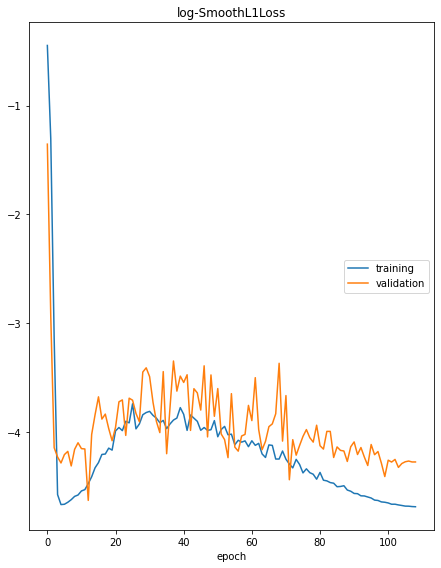

log-SmoothL1Loss
	training         	 (min:   -4.688, max:   -0.447, cur:   -4.688)
	validation       	 (min:   -4.629, max:   -1.354, cur:   -4.276)


In [3]:
m = NeuralProphet(
    yearly_seasonality=3,
    weekly_seasonality=False,
    daily_seasonality=8,
    growth="off",
    learning_rate=0.1,
)
df_train, df_test = m.split_df(sf_pv_df, freq='H', valid_p = 0.10)

metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [4]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
108,0.009207,92.075122,117.748525,0.0,0.013897,131.444336,147.044403


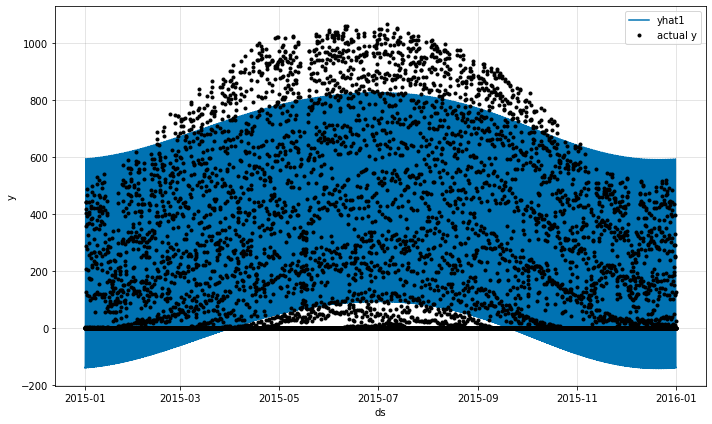

In [5]:
forecast = m.predict(sf_pv_df)
fig = m.plot(forecast)

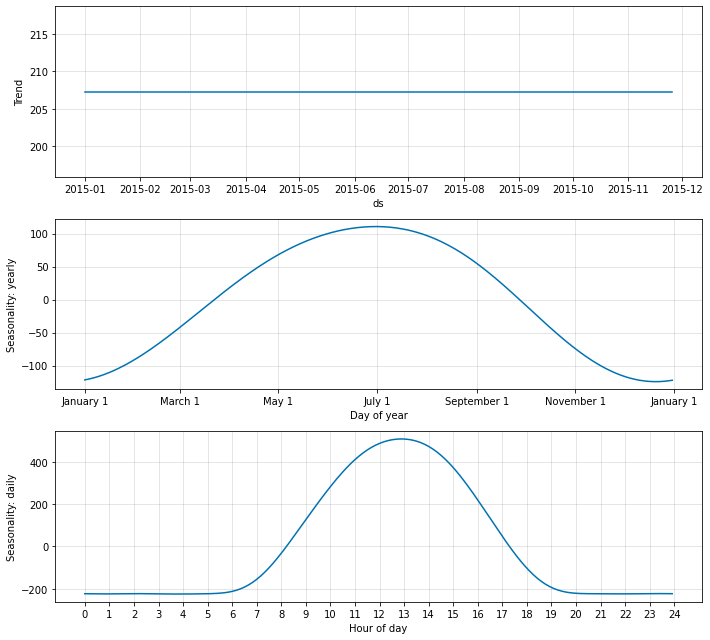

In [6]:
fig_param = m.plot_parameters()


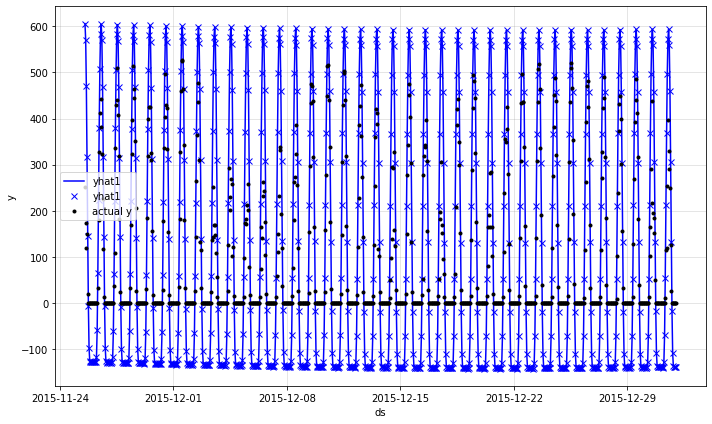

In [7]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

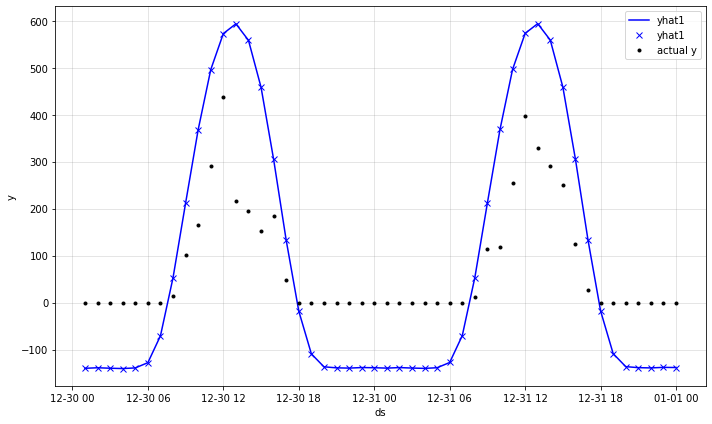

In [8]:
fig_prediction = m.plot(forecast[-48:])


## 1-step ahead forecast with Auto-Regresseion
In this second section, we will train a 1-step ahead forecaster on solar irradiance data (that can be a proxy for solar PV production). We can train this forecaster considering the privious 24 steps and disabling trend and seasonality.

The paramters that we can modify are the number of lags and the AR sparsity.

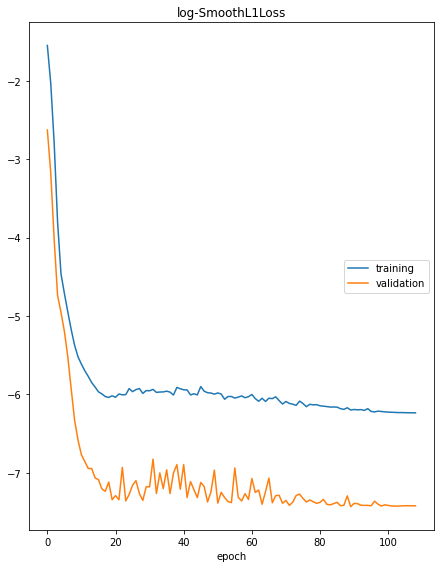

log-SmoothL1Loss
	training         	 (min:   -6.236, max:   -1.550, cur:   -6.236)
	validation       	 (min:   -7.433, max:   -2.628, cur:   -7.421)


In [9]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    learning_rate=0.01,
)

df_train, df_test = m.split_df(sf_pv_df, freq='H', valid_p = 0.10)

metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [10]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
108,0.001958,30.208602,52.474567,0.0,0.000599,18.196203,30.516989


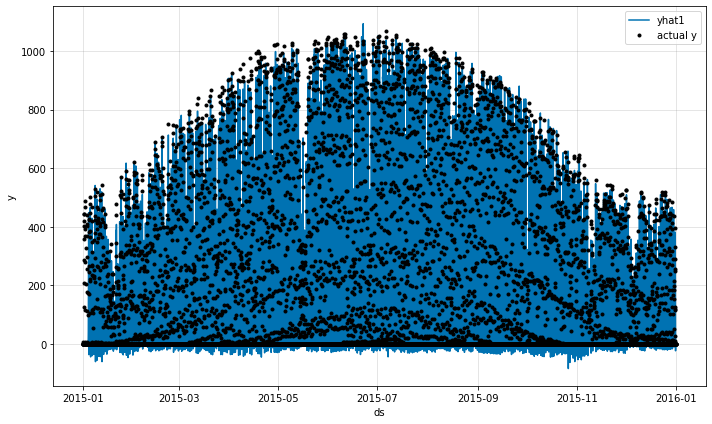

In [11]:
forecast = m.predict(sf_pv_df)
fig = m.plot(forecast)

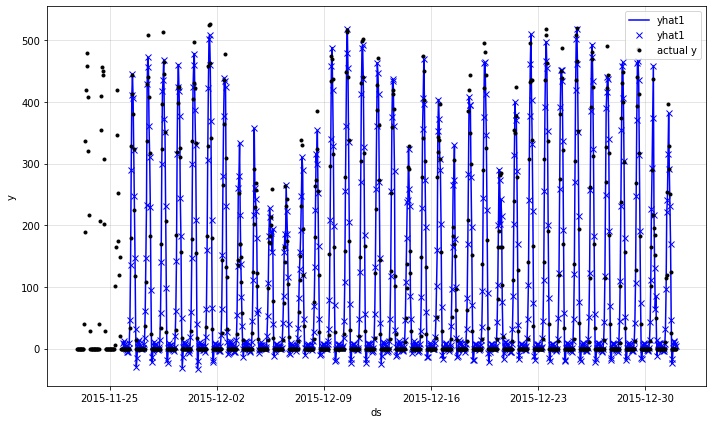

In [12]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

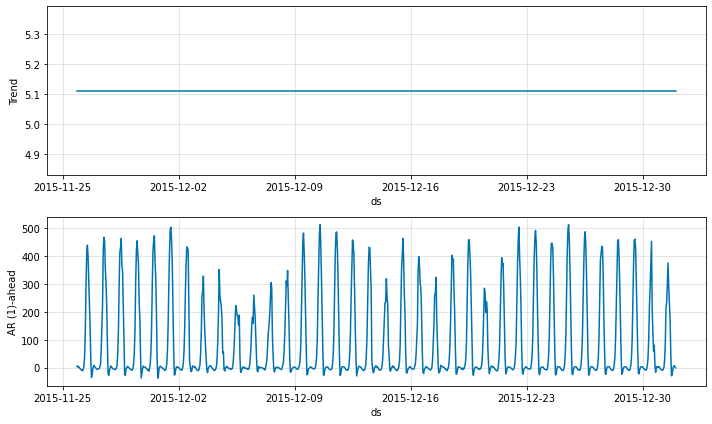

In [13]:
fig_comp = m.plot_components(forecast)

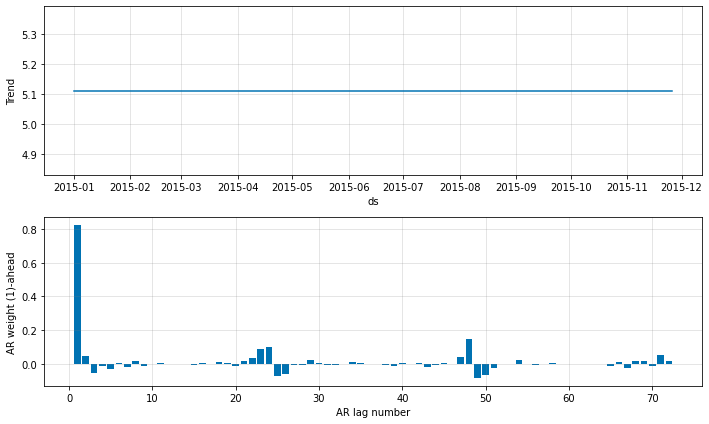

In [14]:
fig_param = m.plot_parameters()


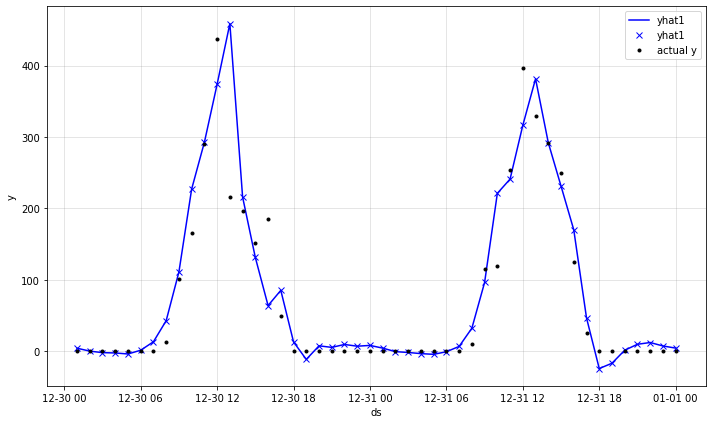

In [15]:
fig_prediction = m.plot(forecast[-48:])


### Sparsifying the AR coefficients
By setting an `ar_sparsity < 1` we can reduce the number of non-zero AR coefficients. 

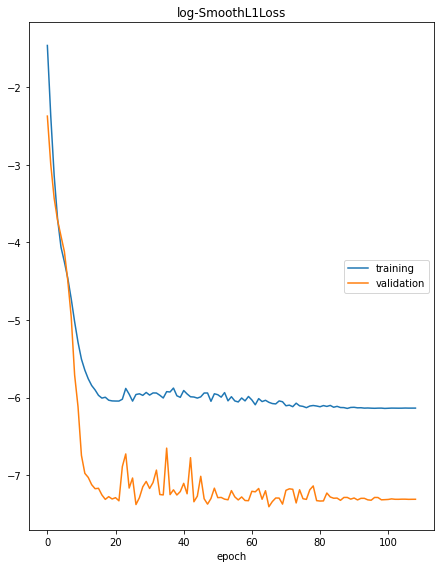

log-SmoothL1Loss
	training         	 (min:   -6.140, max:   -1.461, cur:   -6.136)
	validation       	 (min:   -7.408, max:   -2.371, cur:   -7.312)


In [16]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    ar_sparsity=0.8,
    learning_rate=0.01,
)

df_train, df_test = m.split_df(sf_pv_df, freq='H', valid_p = 0.10)

metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [17]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
108,0.002163,32.035213,55.543879,0.001141,0.000668,17.936563,32.233215


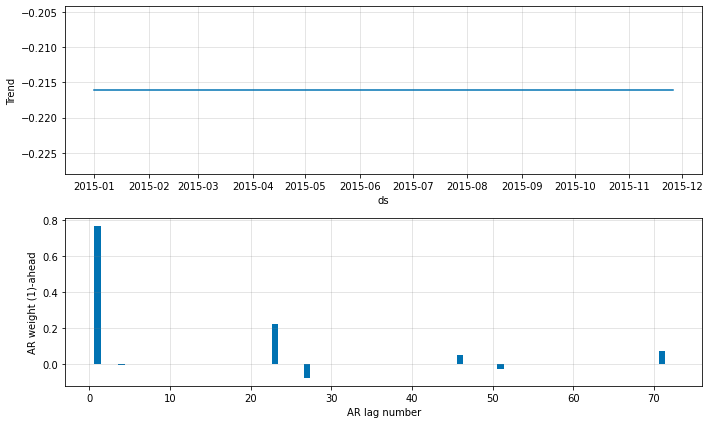

In [18]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig_param = m.plot_parameters()

## 1-step ahead forecast with Auto-Regression including Integration
Next, we will add the differences of the series as a lagged covariate.
This basically extends the model from AR to ARI, where the I stands for 'integrated' time series.

In [19]:
df = sf_pv_df.copy(deep=True)
df["I"] = np.append(0, sf_pv_df["y"].values[1:] - sf_pv_df["y"].values[:-1])
df.tail(3)

,ds,y,I
8757,2015-12-31 22:00:00,0,0
8758,2015-12-31 23:00:00,0,0
8759,2016-01-01 00:00:00,0,0


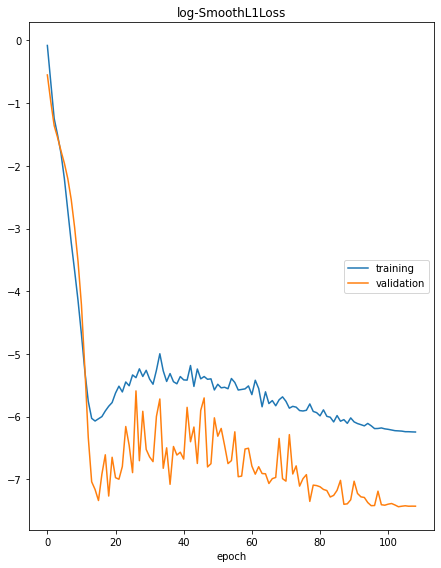

log-SmoothL1Loss
	training         	 (min:   -6.244, max:   -0.080, cur:   -6.244)
	validation       	 (min:   -7.436, max:   -0.551, cur:   -7.427)


In [20]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    learning_rate=0.01,
)
m = m.add_lagged_regressor("I", normalize="standardize")
df_train, df_test = m.split_df(df, freq='H', valid_p = 0.10)

metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [21]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
108,0.001941,29.920344,52.334781,0.0,0.000595,17.958061,30.422981


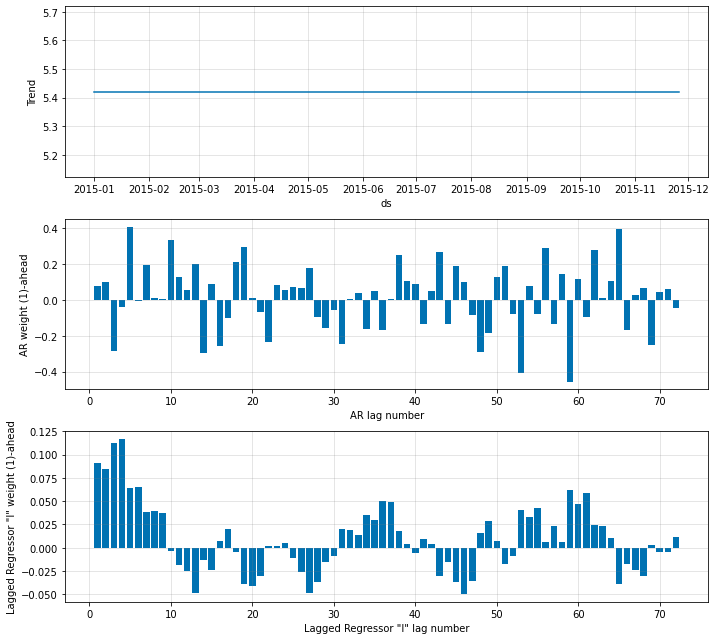

In [22]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig_param = m.plot_parameters()

## 1 step ahead forecast with AR-Net: Using a Neural Network
There is something to consider here, if we consider a neural network with at least one hidden layer: Learning Rate matters when training a Neural Network. 

For a high enough learning rate (probably > 0.1), the gradient seems to vanish and forces the AR net output to 0.  
An easy way to void this issue is to set the learning rate at a low enough value, likely around 0.01 to 0.001.

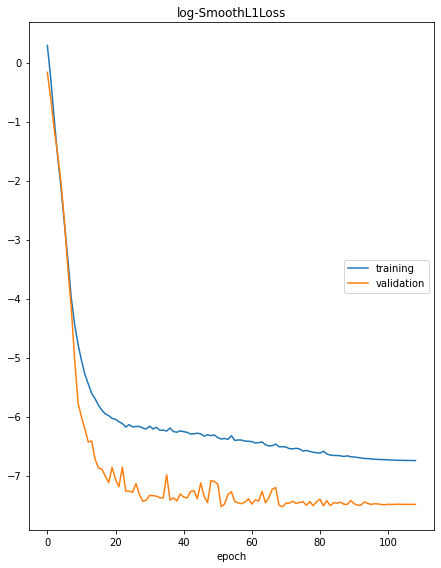

log-SmoothL1Loss
	training         	 (min:   -6.745, max:    0.291, cur:   -6.745)
	validation       	 (min:   -7.528, max:   -0.165, cur:   -7.488)


In [49]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    num_hidden_layers=4,
    d_hidden=8,
    learning_rate=0.003,
)

df = sf_pv_df.copy(deep=True)
df["I"] = np.append(0, sf_pv_df["y"].values[1:] - sf_pv_df["y"].values[:-1])
df_train, df_test = m.split_df(df, freq='H', valid_p = 0.10)
m = m.add_lagged_regressor("I", normalize="standardize")
metrics = m.fit(df_train, freq='H', validation_df=df_test, progress='plot')

In [50]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
108,0.001177,20.775232,40.267807,0.0,0.00056,13.750281,29.512976


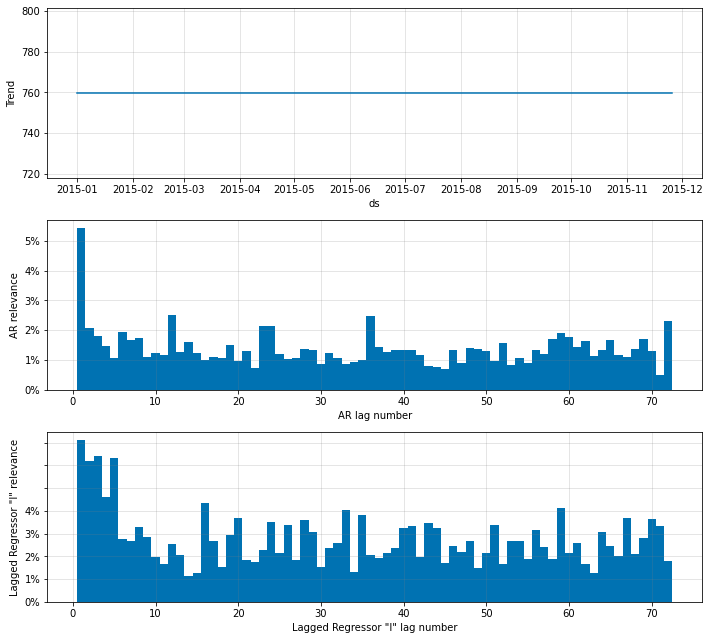

In [51]:
fig = m.plot_parameters()

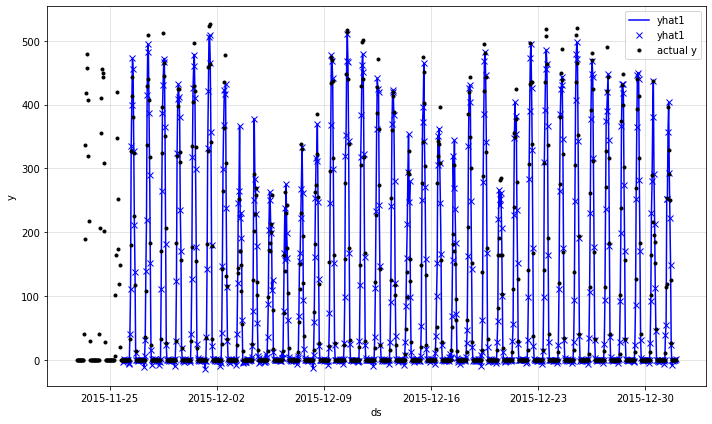

In [52]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
forecast = m.predict(df_test)
fig = m.plot(forecast)

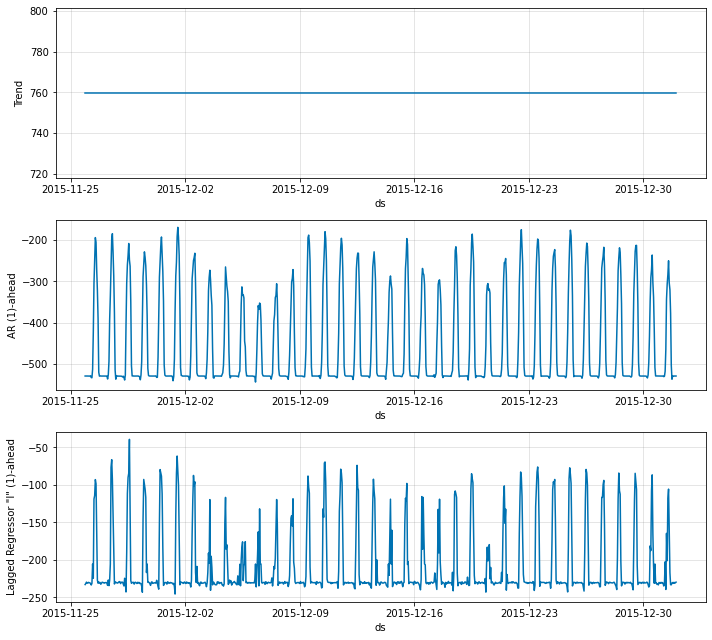

In [53]:
fig_comp = m.plot_components(forecast)

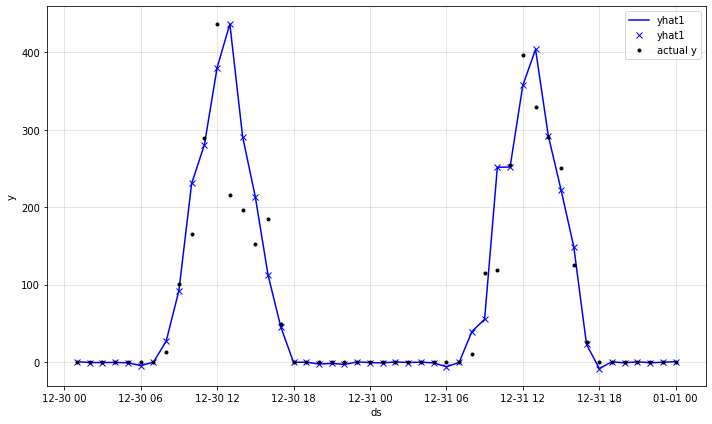

In [54]:
fig_prediction = m.plot(forecast[-48:])